In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import scipy.interpolate as sip
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [3]:
from configs import *
from quantization_model_log import *
from qmc_utils import load_generator, load_data, load_all

In [4]:
from Trans import TransformLog
from CostFunction import CostFunction

In [5]:
z_dimension = 256
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

random_seed = 777
torch.manual_seed(random_seed)
GAN_PATH = 'Model/sngan11_256_unnorm.pt'
GAN_model = load_generator(GAN_PATH, device)

In [6]:
def predict_slf(Z, device=device):
    R = Z.shape[0]//2
    Ar = Z[:R,:,:]
    Br = Z[R:,:,:]

    def ll1_prod(Ar, Br):
        Sr = torch.zeros((Ar.shape[0], 1, Ar.shape[1], Br.shape[1] ) ).to(device)
        for i in range(Br.shape[0]):
            Sr[i,0] = torch.matmul(Ar[i], Br[i].T)

        return Sr

    return ll1_prod(Ar, Br)

In [7]:
def optimize_for(DATA_PATH, SELECT_METHOD, sampling_percent= 0.1, sigma_val = None, R=None):

    random_seed = 83#777
    torch.manual_seed(random_seed)
    
    if SELECT_METHOD == "btd":
        generator = predict_slf
    else:
        generator = GAN_model
    
    #Data loading section
    _, _, _, S_true, C_true, T_true = load_data(DATA_PATH, device)
    
    if R is None:
        R, K = C_true.shape
    else:
        _, K = C_true.shape
        print(R, "is manually set.")
        
    I, J = S_true.shape[1:]
    
    #Create mask for sampling measurements 
    Wx = create_mask_matrix(sampling_percent, fiber=True).to(device)
    params = SelectParameters(bits = 3)
    bin_boundaries = params.QUANTIZATION_BINS.to(device) 

    #Quantization parameters
    if sigma_val is None:
        std_probit  = params.std_probit
    else:
        std_probit = sigma_val


    bias = params.OFFSET

    # Transformation before quantization
    h_eta = TransformLog(offset=bias)
    trans_T = h_eta.trans(T_true)   

    # obtain the observation Y
    Y = quantize(trans_T, std_probit, bin_boundaries, device) #quantization
    Y = Y.unsqueeze(dim=1)
    
    # Create cost function.
    cost_func = CostFunction(Wx, params.lambdda, SELECT_METHOD, bin_boundaries, std_probit, device)

    # S,C,Z are the variables that will be modified during iteration.
    S = torch.zeros( (R, 1, I, J) ).to(device)
    C = 0.1*torch.rand((R, K)).to(device)

    if SELECT_METHOD == "btd":
        L = 10
        print(min(np.floor(I/L), R)+ min(np.floor(J/L), R), R+2, "...>=..." , I, J, K, R, L)
        Z = 1e-1*torch.rand((2*R, I, L)).to(device)
    else:
        Z = torch.randn((R, z_dimension), dtype=torch.float32).to(device) 
        ###This part is not necessary. Just to find the good initial z from GAN latent embedding to start optimization########
        min_criterion = 9999999
        # First Z is sampled from unit variance ball
        for t in range(200):
            temp = torch.randn((R,z_dimension), dtype=torch.float32).to(device)
            temp_out = generator(temp)
            T_hat_ = get_tensor(temp_out, C, device)
            T_hat_ = T_hat_.unsqueeze(dim=1)
            T_hat = h_eta.trans(T_hat_)
            temp_criterion = cost_func.calculate_cost(Y, T_hat, C, Z)

            if  temp_criterion < min_criterion:
                Z.data = temp.clone()
                min_criterion = temp_criterion
    

    Z = Z.detach().clone()
    C.requires_grad = True
    Z.requires_grad = True

    alpha = params.alpha
    beta = params.beta
    optimizerC = torch.optim.Adam([C], lr=alpha)
    optimizerZ = torch.optim.Adam([Z], lr=beta)
    with torch.no_grad():
        S = generator(Z)
    
    
    epsilon = 1e-3
    maxIter = 500 #Maximum Iterations to run for optimizing C and S
    prev_cost = 0
    
    for i in range(maxIter):
        #########################################################
        # C optimization step
        # Avoid adding S to computation graph      
        Sc = S.detach().clone()
        optimizerC.zero_grad()
        T_hat_ = get_tensor(Sc, C, device)
        T_hat_ = T_hat_.unsqueeze(dim=1)
        T_hat = h_eta.trans(T_hat_)
        cost = cost_func.calculate_cost(Y, T_hat, C, Z)
        cost.backward()
        optimizerC.step()
        with torch.no_grad():
            C[C<0] = 0  # Project C to non-negative orthrant

        # S iterations
        #######################################################
        S = generator(Z)
        optimizerZ.zero_grad()
        T_hat_ = get_tensor(S, C, device)
        T_hat_ = T_hat_.unsqueeze(dim=1)
        T_hat = h_eta.trans(T_hat_)
        cost = cost_func.calculate_cost(Y, T_hat, C, Z)
        cost.backward()
        # print("second cost", cost)
        optimizerZ.step()
        if SELECT_METHOD == "btd":
            with torch.no_grad():
                # Projecting A and B to positive orthant
                Z[Z<0] = 0.0

        ############ log performance #####################
        with torch.no_grad():
            T_temp = get_tensor(S,C, device)
            costs = cost.cpu().detach().numpy() 
            log_nmses = NMSE_LOG(T_temp, T_true).cpu().detach().numpy()
            
        #####################################################
        # print('Iterations {}, Cost: {}, LOG-NMSE:{}'.format(i, costs, log_nmses ))
        # print(".."*40)
        if abs(costs - prev_cost) < epsilon:
            break
        
    log_nmses = log_nmses.item()
    if SELECT_METHOD == "btd":
        final_lnmse = (Wx[0].cpu().squeeze().numpy(), log_nmses)
    else:
        final_lnmse = log_nmses      
        
    return T_temp.detach().cpu(), S.detach().cpu(), C.detach().cpu(), final_lnmse

2 emitters.


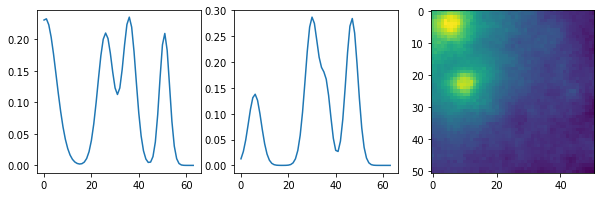

In [8]:
# Load Data

DATA_PATH = "RadioMaps/2_2.mat"
S_init, C_init, T, S_true, C_true, T_true, Z_init, Z = load_all( DATA_PATH, z_dimension, device, visualize_data=True, k=30)

In [9]:
for SELECT_METHOD in ["dgm", "btd"]: 
    print(SELECT_METHOD, "is running.")
    
    metadata = optimize_for(DATA_PATH, SELECT_METHOD, sampling_percent=0.1)

    if SELECT_METHOD == "btd":
        T_raw, S_raw, C_btd, lnmse_raw = metadata
        #Using TPS enhancement (mentioned in btd paper)
        Om, lnmse_btd = lnmse_raw 
        x_sample, y_sample = np.where(Om == 1)

        S_btd = np.zeros( S_raw.shape )
        for idx, S_i in enumerate(S_raw.detach()):
            s = S_i.squeeze()
            s = s[x_sample, y_sample].numpy()
            yi, xi = np.mgrid[0:51, 0:51]
            interp = sip.Rbf(x_sample, y_sample, s, function='thin_plate')
            S_btd[idx, 0] = interp(xi, yi).T

        S_btd = torch.tensor(S_btd)
        S_btd[S_btd <= 0] = torch.quantile(S_btd[S_btd > 0], 0.25)
        T_btd =  get_tensor(S_btd, C_btd, device)
        
    elif SELECT_METHOD == "dgm":
        T_dgm, S_dgm, C_dgm, lnmse_dgm = metadata

dgm is running.
btd is running.
4 4 ...>=... 51 51 64 2 10


Text(0.5, 1.0, 'True Map')

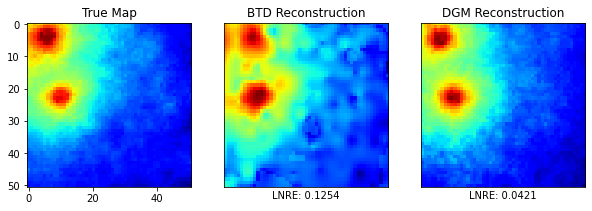

In [10]:
k = 30
radio_maps = [torch.log(i[k,...]).cpu().squeeze().detach().numpy() for i in [T_true, T_btd, T_dgm]]
titles = ['True Map', 'BTD Reconstruction', 'DGM Reconstruction']
lnres = ["LNRE: " + str(i)[:6] for i in [lnmse_btd, lnmse_dgm] ]

fig, ax = plt.subplots(1, 3, figsize=(10,5) )
    
for i in range(2):
    ax[i+1].imshow(radio_maps[i+1], cmap="jet")
    ax[i+1].set_title(titles[i+1])
    ax[i+1].axes.xaxis.set_ticks([])
    ax[i+1].axes.yaxis.set_ticks([])
    ax[i+1].set_xlabel(lnres[i])
    
ax[0].imshow(radio_maps[0], cmap="jet")
ax[0].set_title(titles[0])

